In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy
import numpy as np
import cupy as cp
import math
import json
from PIL import Image, ImageDraw
from scipy.special import factorial

%run utils.ipynb

In [2]:
variant = 'RETINA'
config = Config(variant)

In [3]:
%%time
IMAGE_SIZE = -1
IMAGES = []
IMAGES_METADATA = []

with open(os.path.join(config.dataset_path, config.dataset_metadata_file_name)) as f:
    metadata = json.load(f)

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.width == IMAGE_SIZE or IMAGE_SIZE == -1
        IMAGE_SIZE = image.width
        assert image.mode == 'L'
        image_index = len(IMAGES)
        IMAGES.append(np.array(image).ravel())
        metadata_record = metadata[os.path.basename(image_fname)]
        metadata_record = np.rec.array([(image_fname, metadata_record.get('value', '?'))], dtype=[('file_name', 'object'), ('value', 'object')])
        IMAGES_METADATA.append(metadata_record)
        
    assert image.fp is None

assert len(IMAGES) == len(IMAGES_METADATA)
IMAGES = np.array(IMAGES)
IMAGES_METADATA = np.rec.array(np.concatenate(IMAGES_METADATA))
print(f'Loaded {len(IMAGES)} images')

  0%|          | 0/5002 [00:00<?, ?it/s]

Loaded 5000 images
CPU times: user 646 ms, sys: 62 ms, total: 708 ms
Wall time: 706 ms


In [4]:
device_marker = np.empty(1)
xp = cp.get_array_module(device_marker)

In [5]:
SENSOR_RECEPTIVE_FIELD_SIZE = 8
SENSOR_GROUP_SIZE = 4
RETINA_SIZE = 16

# single sensor occupies (RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE) ^ 2
# we have group of such sensors stacked under each other in a square fashion, hence SENSOR_GROUP_SIZE^2
# to cover all visual area we have RETINA_SIZE^2 of such groups
RETINA = xp.zeros((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))


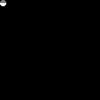
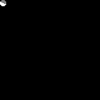
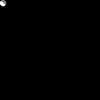
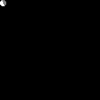
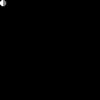
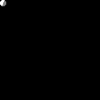
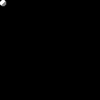
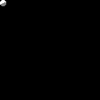
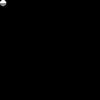
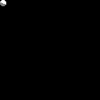
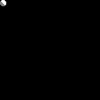
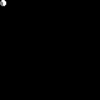
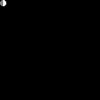
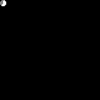
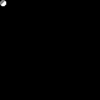
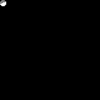

In [6]:
group_sensors_img = []
steps = pow(SENSOR_GROUP_SIZE, 2)
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    draw.ellipse([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], outline=0, fill=127, width=0)
    angle = i * 360 / steps
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    group_sensors_img.append(canvas)

display_images(list(map(lambda x: x.resize((100, 100)), group_sensors_img)))

# canvas = Image.new('L', (100, 100))
# draw = ImageDraw.Draw(canvas)
# draw.chord([0, 0, 100 - 1, 100 - 1], 0, 0 + 180, outline=255, fill=255)

# for i in range(steps):
#     angle = -i * 360 / steps
#     canvas2 = canvas.rotate(angle, resample=Image.Resampling.BICUBIC)
#     group_sensors_img.append(canvas2.resize((8, 8)))

#display_images(group_sensors_img)

In [7]:
group_sensors = xp.array(list(map(xp.array, group_sensors_img))).astype(float)
shape_save = group_sensors.shape
group_sensors = group_sensors.reshape(SENSOR_GROUP_SIZE*SENSOR_GROUP_SIZE, -1)
# Due to rough granularity count of positive pixels and negative may be not eqaul => equalize via weight
group_sensors[group_sensors==255] = 1
counts_of_positives = (group_sensors == 1).sum(axis=1)
counts_of_negatives = (group_sensors == 127).sum(axis=1)
white_image = xp.ones(group_sensors.shape[1])

for i, (p, n) in enumerate(zip(counts_of_positives, counts_of_negatives)):
    assert p > 0, (i, p)
    assert n > 0, (i, n)
    group_sensors[i][group_sensors[i] == 127] = -1 * (p / n)
    v = group_sensors[i] @ white_image
    assert xp.isclose(v, 0), v

group_sensors = group_sensors.reshape(shape_save)
group_sensors.shape, np.unique_counts(group_sensors)

((16, 128, 128),
 UniqueCountsResult(values=array([-1.36363636, -1.26086957, -1.16666667, -1.08      , -1.        ,
         0.        ,  1.        ]), counts=array([    44,    138,     48,     50,    104, 261312,    448])))

In [8]:
np.unique(group_sensors[0]), counts_of_negatives

(array([-1.,  0.,  1.]),
 array([26, 25, 23, 24, 26, 24, 23, 25, 26, 23, 23, 22, 26, 22, 23, 23]))

In [9]:
p, n, p/n

(np.int64(29), np.int64(23), np.float64(1.2608695652173914))


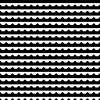
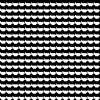
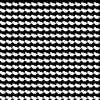
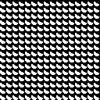
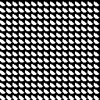
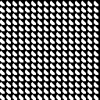
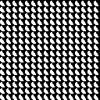
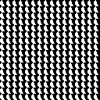
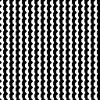
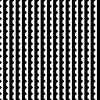
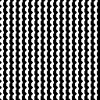
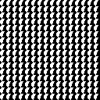
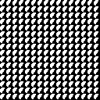
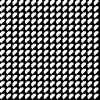
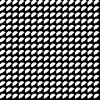
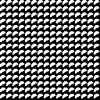
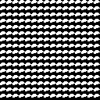
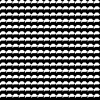
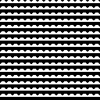
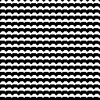

In [10]:
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
steps = 36 # 10 degreee
specific_samples_img = []

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    angle = i * 360 / steps
    
    # coords = [-SENSOR_RECEPTIVE_FIELD_SIZE, -SENSOR_RECEPTIVE_FIELD_SIZE, SENSOR_RECEPTIVE_FIELD_SIZE*2 - 1, SENSOR_RECEPTIVE_FIELD_SIZE*2 - 1]
    # draw.chord(coords, angle, angle + 180, outline=255, fill=255)
    # draw.rectangle([SENSOR_RECEPTIVE_FIELD_SIZE, 0, sz, sz], fill=0)
    # draw.rectangle([0, SENSOR_RECEPTIVE_FIELD_SIZE, sz, sz], fill=0)
    
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    crop = canvas.crop([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE, SENSOR_RECEPTIVE_FIELD_SIZE])

    for x in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
        for y in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
            canvas.paste(crop, [x, y, x + SENSOR_RECEPTIVE_FIELD_SIZE, y + SENSOR_RECEPTIVE_FIELD_SIZE])
            
    specific_samples_img.append(canvas)

display_images(list(map(lambda x: x.resize((100, 100)), specific_samples_img[:20])))

In [11]:
SPECIFIC_SAMPLES = xp.array(list(map(xp.array, specific_samples_img))).astype(float)
SPECIFIC_SAMPLES[SPECIFIC_SAMPLES==255] = 1
SPECIFIC_SAMPLES = SPECIFIC_SAMPLES.reshape(SPECIFIC_SAMPLES.shape[0], -1)
SPECIFIC_SAMPLES.shape, np.unique_counts(SPECIFIC_SAMPLES)

((36, 16384),
 UniqueCountsResult(values=array([0., 1.]), counts=array([331776, 258048])))

In [12]:
RETINA = RETINA.reshape((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))

for y in range(RETINA_SIZE):
    for x in range(RETINA_SIZE):
        for g in range(pow(SENSOR_GROUP_SIZE, 2)):
            sensor_at_place = group_sensors[g]
            sensor_at_place = np.roll(sensor_at_place, y * SENSOR_RECEPTIVE_FIELD_SIZE, axis=0)
            sensor_at_place = np.roll(sensor_at_place, x * SENSOR_RECEPTIVE_FIELD_SIZE, axis=1)
            RETINA[y, x, g, :] = sensor_at_place.reshape(-1)

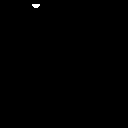

In [13]:
Image.frombytes('L', size=(sz, sz), data=RETINA[0,4,0].astype(xp.uint8) * 255)

In [14]:
RETINA = RETINA.reshape((-1, pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))

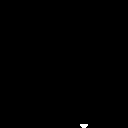

In [15]:
Image.frombytes('L', size=(sz, sz), data=RETINA[4000].astype(xp.uint8) * 255)

In [16]:
specific_samples_sense_res = (RETINA @ SPECIFIC_SAMPLES.T > 0).astype(xp.uint8)
specific_samples_sense_res.shape

(4096, 36)

In [17]:
specific_samples_sense_res = specific_samples_sense_res.reshape(RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1)
specific_samples_sense_res.shape

(16, 16, 16, 36)

In [18]:
for i in range(SPECIFIC_SAMPLES.shape[0]):
    print(specific_samples_sense_res[2, 3, :, i])

[1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1]
[1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1]
[1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1]
[1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1]
[1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1]
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1]
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1]
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
[0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
[0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
[0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
[0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
[0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
[0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0]
[0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0]
[0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0]
[0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0]
[0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0]
[0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0]
[0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
[1 0 0 0 0 0 0

In [297]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image


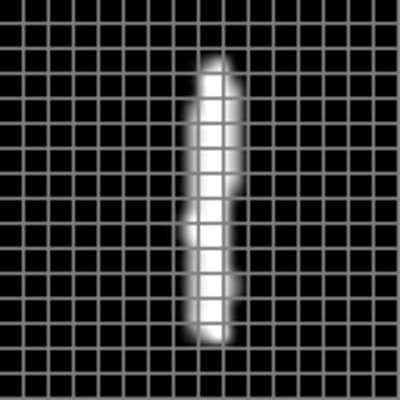
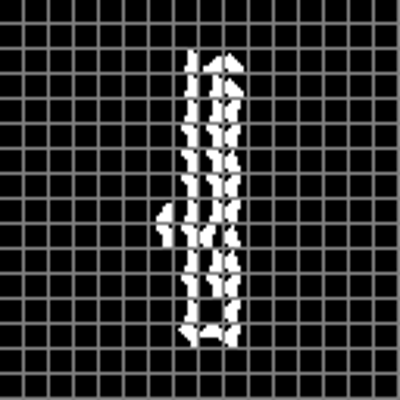

In [321]:
original_img = IMAGES[10] # 10 - вертикальная единичка
sense_res = RETINA @ original_img
sense_res = sense_res.reshape(RETINA_SIZE, RETINA_SIZE, -1)

sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
sensed_image = np.zeros((sz, sz))

for y in range(sense_res.shape[0]):
    for x in range(sense_res.shape[1]):
        sense_vector = (sense_res[y, x] > 1).astype(xp.uint8)
        # Find most similar reaction among specific samples of reactions
        sense_vector_match = sense_vector @ specific_samples_sense_res[y, x, :]

        if sense_vector_match.max() > 6:
            max_i = xp.argmax(sense_vector_match)
            most_similar_specific_sample = SPECIFIC_SAMPLES[max_i].reshape((sz, sz))
            srfs = SENSOR_RECEPTIVE_FIELD_SIZE
            np.copyto(sensed_image[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs], most_similar_specific_sample[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs])

images = [lay_grid(Image.frombytes('L', size=(sz, sz), data=(original_img).astype(np.uint8)), SENSOR_RECEPTIVE_FIELD_SIZE), 
          lay_grid(Image.frombytes('L', size=(sz, sz), data=(sensed_image * 255).astype(np.uint8)), SENSOR_RECEPTIVE_FIELD_SIZE)]
display_images(list(map(lambda x: x.resize((400, 400)), images)))

In [301]:
sense_res[4,8].reshape(4,4)

array([[  32.        , -136.8       , -190.60869565, -194.        ],
       [-200.        , -194.        , -186.08695652, -161.76      ],
       [ -32.        ,   78.43478261,  216.34782609,  285.81818182],
       [ 200.        ,  281.09090909,  229.91304348,  134.95652174]])

In [391]:
z = original_img.reshape(128, 128)
i = 4
j = 8
zpart = z[i*8:(i+1)*8,j*8:(j+1)*8]
zpart, zpart.shape

(array([[195, 232, 255, 255, 255, 255, 255, 246],
        [205, 235, 255, 255, 255, 255, 255, 246],
        [212, 237, 255, 255, 255, 255, 255, 246],
        [218, 239, 255, 255, 255, 255, 255, 246],
        [223, 241, 254, 255, 255, 255, 255, 246],
        [226, 243, 254, 255, 255, 255, 255, 246],
        [229, 244, 254, 255, 255, 255, 255, 246],
        [231, 244, 254, 255, 255, 255, 255, 246]], dtype=uint8),
 (8, 8))

In [393]:
aaa = RETINA.reshape(16,16,16,-1)[4,8,:]
aaa.shape

(16, 16384)

In [406]:
aaa2 = aaa.reshape(16,128,128)
aaa2 = aaa2[:,i*8:(i+1)*8,j*8:(j+1)*8]
aaa2 = aaa2.reshape(16,-1)
aaa2 @ zpart.reshape(-1)

array([  32.        , -136.8       , -190.60869565, -194.        ,
       -200.        , -194.        , -186.08695652, -161.76      ,
        -32.        ,   78.43478261,  216.34782609,  285.81818182,
        200.        ,  281.09090909,  229.91304348,  134.95652174])

In [413]:
np.round(aaa2[13].reshape(8,8), 2)

array([[ 0.  ,  0.  , -1.36, -1.36, -1.36,  1.  ,  0.  ,  0.  ],
       [ 0.  , -1.36, -1.36, -1.36,  1.  ,  1.  ,  1.  ,  0.  ],
       [-1.36, -1.36, -1.36, -1.36,  1.  ,  1.  ,  1.  ,  1.  ],
       [-1.36, -1.36, -1.36, -1.36,  1.  ,  1.  ,  1.  ,  1.  ],
       [-1.36, -1.36, -1.36, -1.36,  1.  ,  1.  ,  1.  ,  1.  ],
       [-1.36, -1.36, -1.36,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ],
       [ 0.  , -1.36,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.  ,  0.  ]])


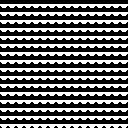
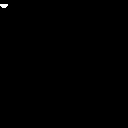
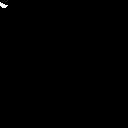
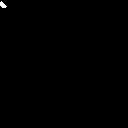
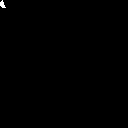
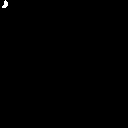
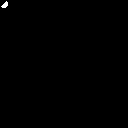
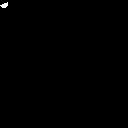

In [271]:
sample_index = 0
z = RETINA @ SPECIFIC_SAMPLES.T
z = z.reshape(16, 16, 16, -1)
t = (z[0,0,:,sample_index] > 0).astype(np.uint8).reshape(4,4)
w = group_sensors.reshape(4, 4, (sz*sz))
images = []

for i in range(t.shape[0]):
    for j in range(t.shape[1]):
        if t[i,j] > 0:
            data = w[i,j]
            data[data < 0] = 0
            data[data == 1] = 255
            img = Image.frombytes('L', size=(sz, sz), data=data.astype(np.uint8))
            images.append(img)

images.insert(0, Image.frombytes('L', size=(sz, sz), data=(SPECIFIC_SAMPLES[sample_index] * 255).astype(np.uint8)))
display_images(images)


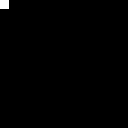

In [270]:
white_sample = Image.new('L', size=(sz, sz))
ImageDraw.Draw(white_sample).rectangle([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE, SENSOR_RECEPTIVE_FIELD_SIZE], fill=255)
white_sample_data = xp.array(white_sample).reshape(-1)

z = RETINA @ white_sample_data
z = z.reshape(16, 16, 16, -1)
t = (z[0,0,:,0] > 1).astype(np.uint8).reshape(4,4)
w = group_sensors.reshape(4, 4, (sz*sz))
images = []

for i in range(t.shape[0]):
    for j in range(t.shape[1]):
        if t[i,j] > 0:
            data = w[i,j]
            data[data < -1] = 0
            data[data == 1] = 255
            img = Image.frombytes('L', size=(sz, sz), data=data.astype(np.uint8))
            images.append(img)

images.insert(0, white_sample)
display_images(images)